# Tutorial with 1d advection equation

Code pipeline from the PNAS 2020 paper by Jiawei Zhuang et al. 

In [1]:
# %%capture
# !pip install -U numpy==1.18.5
# !pip install h5py==2.10.0

In [2]:
'Comment above cell and restart and run all before'

'Comment above cell and restart and run all before'

In [3]:
'Check numpys version BEFORE and AFTER runtime restart'
import numpy as np
import matplotlib.pyplot as plt
print(np.__version__)

1.18.5


# Setup

In [18]:
%%capture
!git clone https://github.com/aditya5252/Multiprocessor_Advection_.git
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
%tensorflow_version 1.x

import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from google.colab import files  # colab-specific utilities; comment out when running locally

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils
# tf.keras.backend.set_floatx('float32')


In [19]:
'Find dt for Advection-1d equation'
def _dx_dt(data,adv_coff):
    dx=2*np.pi/(data.shape[1])
    return dx,dx*0.08/adv_coff

'Plot time propagation of dataset'
def plot_time_prop(data,t0,t1,t2):
  plt.plot(data[t0],label=f'Max_{t0}={data[t0].max()}')
  plt.plot(data[t1],label=f'Max_{t1}={data[t1].max()}')
  plt.plot(data[t2],label=f'Max_{t2}={data[t2].max()}')
  plt.legend()

'Create initial_state dictionary from dataset'
def create_init_state_from_2d_data(data,adv_coff):
  c_init=data[0][np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': adv_coff*np.ones(c_init.shape, np.float32) * 1.0,
      'y_velocity': np.zeros(c_init.shape, np.float32)
  }

  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj

'Create xarray DatArray from integrated dictionary'
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(-1),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr


def delay_(max_delay,prob_dist):
  allowed_delays=np.arange(0.,max_delay)
  delay_chosen=choice(allowed_delays,p=prob_dist)
  return delay_chosen

def modify_data(sub_data,DAsync=None):
  one_arr=np.ones_like(sub_data)

  boundary_arr=np.zeros_like(sub_data)
  boundary_arr[:,0]=1.
  boundary_arr[:,-1]=1.

  if (DAsync==0):
    delay_arr=np.zeros_like(sub_data)
  elif (DAsync==1):
    delay_arr=np.zeros_like(sub_data)
    for i in range(delay_arr.shape[0]):
      delay_arr[i,0]=delay_(nlevels,prob_set)
      delay_arr[i,-1]=delay_(nlevels,prob_set)

  del_arr = delay_arr + boundary_arr + one_arr 
  sub_data_modified=np.multiply(del_arr,sub_data)

  return sub_data_modified


In [20]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):
  'What does this function do'
  'Runs high-accuracy model at high-resolution'
  'smaller dx, => More Nx   => More Nt'
  'Subsample with  subsampling_factor=Resamplingfactor '
  'High accuracy data achieved on a coarse grid'
  'So essentially obtain coarse-grained, HIGH-ACCURACY, GROUND TRUTH data'
  'Return dict of items'


  'For my simple use-case , Resamplingfactor = 1 '
  'Hence, given sync_data dataset(128 x 32)'
  'sync_data dataset itself is taken as the ground truth'
  'Hence we do not need this function to obtain Ground truth data '

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.08)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


In [21]:
def ground_dict_from_data(data):
  conc_ground=tf.convert_to_tensor(data[:,np.newaxis,:,np.newaxis], dtype=tf.float32, dtype_hint=None, name=None)
  ground_soln_dict = {
      'concentration': conc_ground,  # tensorflow code expects float32
      'x_velocity': tf.ones_like(conc_ground, dtype=None, name=None) * 1.0,
      'y_velocity': tf.zeros_like(conc_ground, dtype=None, name=None)
  }
  for k, v in ground_soln_dict.items():
    print(k, v.shape)   # (sample, x, y)
  return ground_soln_dict

def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

# Define Grids & Get Data from Analytical Solution

In [22]:
err_ls=[]

(16, 1)
concentration (1, 16, 1)
x_velocity (1, 16, 1)
y_velocity (1, 16, 1)
True
CPU times: user 4.75 s, sys: 16.2 ms, total: 4.77 s
Wall time: 7.21 s


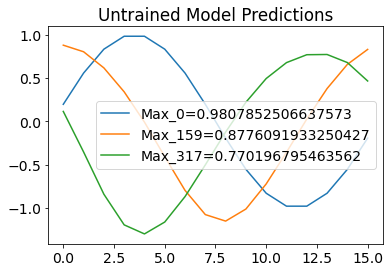

concentration (318, 1, 16, 1)
x_velocity (318, 1, 16, 1)
y_velocity (318, 1, 16, 1)

 train_input shape:
concentration (314, 16, 1)
x_velocity (314, 16, 1)
y_velocity (314, 16, 1)

 train_output shape: (314, 4, 16, 1)
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


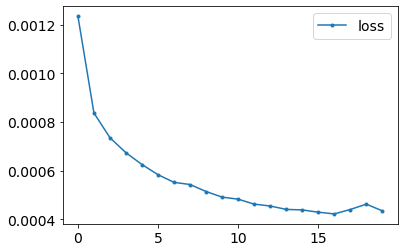

CPU times: user 2.83 s, sys: 7.43 ms, total: 2.84 s
Wall time: 2.84 s


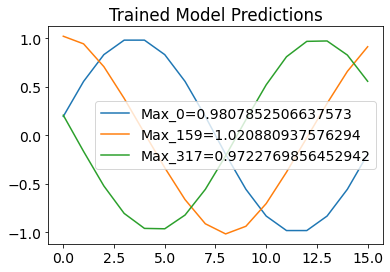

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True
CPU times: user 5.47 s, sys: 12.4 ms, total: 5.48 s
Wall time: 5.48 s


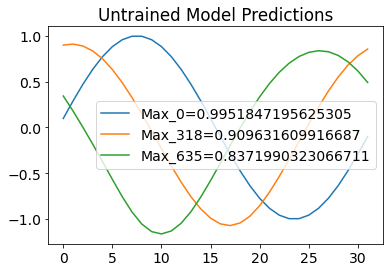

concentration (636, 1, 32, 1)
x_velocity (636, 1, 32, 1)
y_velocity (636, 1, 32, 1)

 train_input shape:
concentration (632, 32, 1)
x_velocity (632, 32, 1)
y_velocity (632, 32, 1)

 train_output shape: (632, 4, 32, 1)
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


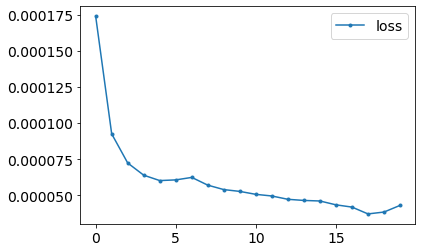

CPU times: user 5.49 s, sys: 15.8 ms, total: 5.5 s
Wall time: 5.53 s


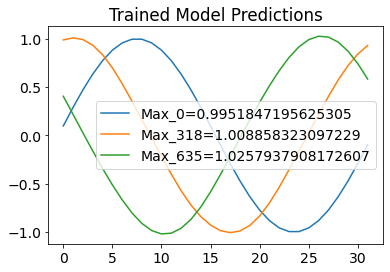

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)
True
CPU times: user 12.3 s, sys: 29.1 ms, total: 12.3 s
Wall time: 12.7 s


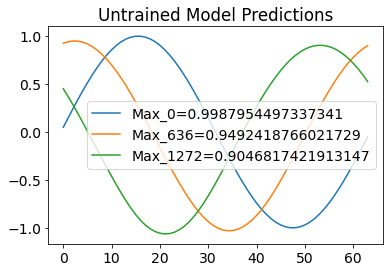

concentration (1273, 1, 64, 1)
x_velocity (1273, 1, 64, 1)
y_velocity (1273, 1, 64, 1)

 train_input shape:
concentration (1269, 64, 1)
x_velocity (1269, 64, 1)
y_velocity (1269, 64, 1)

 train_output shape: (1269, 4, 64, 1)
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs


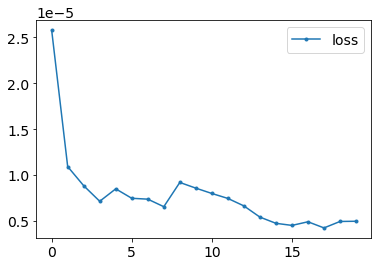

CPU times: user 11 s, sys: 30.1 ms, total: 11.1 s
Wall time: 11 s


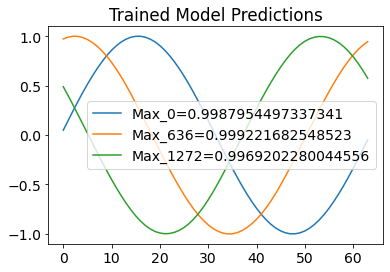

(128, 1)
concentration (1, 128, 1)
x_velocity (1, 128, 1)
y_velocity (1, 128, 1)
True
CPU times: user 23.4 s, sys: 45.3 ms, total: 23.4 s
Wall time: 23.4 s


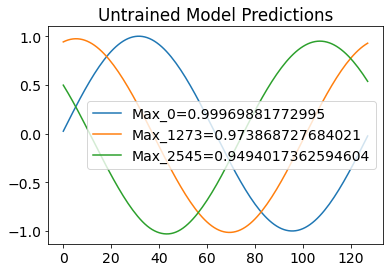

concentration (2546, 1, 128, 1)
x_velocity (2546, 1, 128, 1)
y_velocity (2546, 1, 128, 1)

 train_input shape:
concentration (2542, 128, 1)
x_velocity (2542, 128, 1)
y_velocity (2542, 128, 1)

 train_output shape: (2542, 4, 128, 1)
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.3 µs


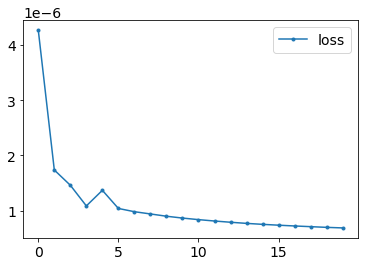

CPU times: user 23.4 s, sys: 52.8 ms, total: 23.5 s
Wall time: 23.5 s


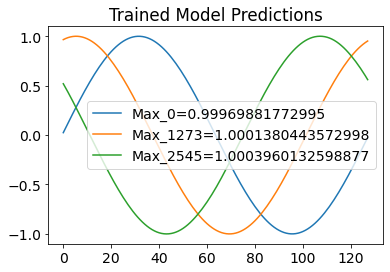

In [23]:
# we mostly run simulation on coarse grid
# the fine grid is only for obtaining training data and generate the reference "truth"
for ord in range(4,8):
  res=2**ord
  numPE=1
  grid_length = 2*np.pi
  fine_grid_resolution = res
  # 1d domain, so only 1 point along y dimension
  fine_grid = grids.Grid(
      size_x=fine_grid_resolution, size_y=1, 
      step=grid_length/fine_grid_resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  print(x_fine.shape)

  #Data on 1000 time-steps
  init_values=np.sin(x_fine)
  CFL=0.08
  u0=1.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/u0
  tend=10.
  N_t=int(tend//dt)
  data_ls=[np.sin(x_fine-u0*dt*n) for n in range(N_t)]
  data_ana=np.stack(data_ls)

  'Create initial state from data'
  data_ana=np.squeeze(data_ana)
  initial_state=create_init_state_from_2d_data(data_ana,u0)
  model_nn = models.PseudoLinearModel(
    advection_equations.FiniteDifferenceAdvection(0.08), 
    fine_grid,
    num_time_steps=4,  # multi-step loss function
    stencil_size=3, kernel_size=(3, 1), num_layers=4, filters=32,
    constrained_accuracy_order=1, 
    learned_keys = {'concentration_x', 'concentration_y'},  # finite volume view, use edge concentration
    activation='relu',)
  print(advection_equations.FiniteDifferenceAdvection(0.08).get_time_step(fine_grid,u0) == dt)
  tf.random.set_random_seed(14)
  time_steps=np.arange(N_t)
  %time integrated_untrained = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_untrained['concentration'].numpy().squeeze(),0,N_t//2,N_t-1)
  plt.title('Untrained Model Predictions')
  plt.show()

  ground_soln_dict=ground_dict_from_data(data_ana)
  train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 4)
  %%time 
  # same as training standard Keras model
  model_nn.compile(
      optimizer='adam', loss='mae'
      )

  # tf.random.set_random_seed(42)
  # np.random.seed(42)
  history = model_nn.fit(
      train_input, train_output, epochs=20, batch_size=64, 
      verbose=0, shuffle=True
      )
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()
  time_steps=np.arange(N_t)
  %time integrated_trained = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_trained['concentration'].numpy().squeeze(),0,N_t//2,N_t-1)
  plt.title('Trained Model Predictions')
  plt.show()
  erAr=integrated_trained['concentration'].numpy().squeeze()[N_t-1]-data_ana[N_t-1]
  err_=np.mean(np.abs(erAr))
  err_ls.append(err_)

# Calculate O.O.A

In [24]:
type(err_ls)

list

In [25]:
err_ls=np.array(err_ls)

In [26]:
ls=np.array([2**i for i in range(4,8)])
print(ls)
print(np.log(ls))

[ 16  32  64 128]
[2.77258872 3.4657359  4.15888308 4.85203026]


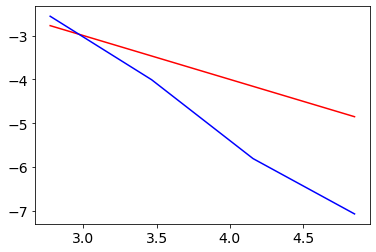

In [27]:
plt.plot(np.log(ls),-1*np.log(ls),'r')
plt.plot(np.log(ls),np.log(err_ls),'b')

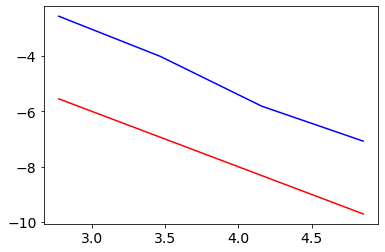

In [28]:
plt.plot(np.log(ls),-2*np.log(ls),'r')
plt.plot(np.log(ls),np.log(err_ls),'b')

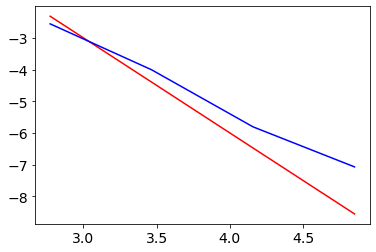

In [29]:
plt.plot(np.log(ls),-3*np.log(ls)+6,'r')
plt.plot(np.log(ls),np.log(err_ls),'b')